In [1]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 15
from itertools import *

In [2]:
import pandas as pd
import numpy as np

In [3]:
corpus_path = "../../Corpus/serialised/hansard.csv"
corpus = pd.read_csv(corpus_path, index_col=0)

corpus

,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader
0,2003-08-12,QUESTIONS WITHOUT NOTICE,QUESTIONS WITHOUT NOTICE,"Crean, Simon, MP",Hotham,ALP,False,False,Leave granted.,ALP,False,True
1,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Howard, John, MP",Bennelong,LP,True,False,That this House: (1) endorses the Government's...,LNC,True,True
2,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Crean, Simon, MP",Hotham,ALP,False,False,Under very difficult circumstances the Solomon...,ALP,False,True
3,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Downer, Alexander, MP",Mayo,LP,True,False,Ever since its independence the Solomon Island...,LNC,False,True
4,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Rudd, Kevin, MP",Griffith,ALP,False,False,"Finally, we support this mission because it ac...",ALP,True,True
5,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,False,False,"Of course you would be aware, Mr Speaker, as a...",ALP,False,True
6,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,False,False,It is the usual practice in this House for the...,ALP,False,True
7,2003-08-12,PRIVILEGE,PRIVILEGE,"Abbott, Tony, MP",Warringah,LP,True,False,Yet again on this issue the opposition have al...,LNC,True,True
8,2003-08-12,PRIVILEGE,PRIVILEGE,"Gillard, Julia, MP",Lalor,ALP,False,False,The obligation on the Prime Minister was quite...,ALP,True,False
9,2003-08-12,MISCELLANEOUS,MAIN COMMITTEE,"Lloyd, Jim, MP",Robertson,LP,True,False,Question agreed to.,LNC,False,False


In [227]:
test_corpus_path = "../../Corpus/serialised/hansard_2012_2014.csv"
test_corpus = pd.read_csv(test_corpus_path, index_col=0)

test_corpus

,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader
0,2013-06-27,MINISTERIAL ARRANGEMENTS,MINISTERIAL ARRANGEMENTS,"Rudd, Kevin, MP",Griffith,ALP,NaN,NaN,I inform the House that last evening the Feder...,ALP,True,True
1,2013-06-27,BUSINESS,BUSINESS,"Morrison, Scott, MP",Cook,LP,NaN,NaN,This parliament has sought to have this matter...,LNC,False,False
2,2013-06-27,BUSINESS,BUSINESS,"Albanese, Anthony, MP",Grayndler,ALP,NaN,NaN,The only section of this bill that remains to ...,ALP,False,False
3,2013-06-27,COMMITTEES,COMMITTEES,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,Leave granted. In accordance with standing ord...,OTHER,False,False
4,2013-06-27,COMMITTEES,COMMITTEES,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,Leave granted.,OTHER,False,False
5,2013-06-27,PARLIAMENTARY REPRESENTATION,PARLIAMENTARY REPRESENTATION,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,I have just come from a morning tea with some ...,OTHER,False,False
6,2013-06-27,COMMITTEES,COMMITTEES,"Marino, Nola, MP",Forrest,LP,NaN,NaN,In accordance with standing order 39(f) the re...,LNC,False,False
7,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False
8,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False
9,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False


In [4]:
import nltk
import gensim
import gensim.models.doc2vec as doc2vec

In [ ]:

tokenized_docs = map(nltk.word_tokenize,map(str.lower, corpus.text))
docs = list(map(lambda case: doc2vec.TaggedDocument(*case),
                zip(tokenized_docs, map(lambda i: (i,),corpus.index))))

In [ ]:
import pickle
docs = None
with open("hansard_texts.pickle", "br") as docs_fs:
    docs = pickle.load(docs_fs)

In [ ]:
model = doc2vec.Doc2Vec(#docs,
        size=300, 
        alpha=0.025,
        window=8, 
        min_count=5,
        sample=0,
        workers=12,
        min_alpha=0.0001,
        dm=1,
        hs=1,
        negative=5,
        dm_mean=0)
model.build_vocab(docs)

In [ ]:
alpha, min_alpha, passes = (0.025, 0.0001, 1000)
alpha_delta = (alpha - min_alpha) / passes
import random


for epoch in range(passes):
    random.shuffle(docs)
    model.alpha, model.min_alpha = alpha, alpha
    
    model.train(docs)
        
    print('completed pass %i at alpha %f' % (epoch + 1, alpha))
    alpha -= alpha_delta
    


In [7]:
model = None
import pickle
with open("hansard_model_1000.pickle", "br") as model_fs:
    model = pickle.load(model_fs)

In [8]:
corpus["embeddings"]= list(model.docvecs)
corpus


,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader,embeddings
0,2003-08-12,QUESTIONS WITHOUT NOTICE,QUESTIONS WITHOUT NOTICE,"Crean, Simon, MP",Hotham,ALP,False,False,Leave granted.,ALP,False,True,"[-0.00173749, -0.188529, -0.0853968, -0.335789..."
1,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Howard, John, MP",Bennelong,LP,True,False,That this House: (1) endorses the Government's...,LNC,True,True,"[-0.159696, -0.422597, -0.164349, 0.497615, 0...."
2,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Crean, Simon, MP",Hotham,ALP,False,False,Under very difficult circumstances the Solomon...,ALP,False,True,"[0.270865, -0.298372, -0.153325, 0.344536, 0.1..."
3,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Downer, Alexander, MP",Mayo,LP,True,False,Ever since its independence the Solomon Island...,LNC,False,True,"[-0.0135467, -0.317893, -0.102762, -0.163063, ..."
4,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Rudd, Kevin, MP",Griffith,ALP,False,False,"Finally, we support this mission because it ac...",ALP,True,True,"[0.0832626, -0.506705, 0.0990901, 0.324263, 0...."
5,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,False,False,"Of course you would be aware, Mr Speaker, as a...",ALP,False,True,"[-0.234017, -0.00745235, -0.11709, 0.729882, -..."
6,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,False,False,It is the usual practice in this House for the...,ALP,False,True,"[0.150429, -0.444132, -0.0869764, 0.395207, 0...."
7,2003-08-12,PRIVILEGE,PRIVILEGE,"Abbott, Tony, MP",Warringah,LP,True,False,Yet again on this issue the opposition have al...,LNC,True,True,"[0.143048, -0.315718, -0.166213, -0.101754, 0...."
8,2003-08-12,PRIVILEGE,PRIVILEGE,"Gillard, Julia, MP",Lalor,ALP,False,False,The obligation on the Prime Minister was quite...,ALP,True,False,"[0.310825, -0.716411, 0.266924, 0.184928, 0.31..."
9,2003-08-12,MISCELLANEOUS,MAIN COMMITTEE,"Lloyd, Jim, MP",Robertson,LP,True,False,Question agreed to.,LNC,False,False,"[0.222024, -0.716405, -0.064718, -0.113805, 0...."


In [243]:
X= np.row_stack(corpus.embeddings)
np.save("phrase_embeddings3_1000gen.npy",X)

In [241]:
test_embeddings = [model.infer_vector(nltk.word_tokenize(str.lower(text))) for text in test_corpus.text]
test_corpus["embeddings"]= test_embeddings
X_test = np.row_stack(test_corpus.embeddings)
test_corpus


,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader,embeddings
0,2013-06-27,MINISTERIAL ARRANGEMENTS,MINISTERIAL ARRANGEMENTS,"Rudd, Kevin, MP",Griffith,ALP,NaN,NaN,I inform the House that last evening the Feder...,ALP,True,True,"[-0.0136404, -0.133396, -0.156523, 0.259823, -..."
1,2013-06-27,BUSINESS,BUSINESS,"Morrison, Scott, MP",Cook,LP,NaN,NaN,This parliament has sought to have this matter...,LNC,False,False,"[0.0450708, -0.167292, -0.168836, 0.337831, -0..."
2,2013-06-27,BUSINESS,BUSINESS,"Albanese, Anthony, MP",Grayndler,ALP,NaN,NaN,The only section of this bill that remains to ...,ALP,False,False,"[-0.0383432, -0.273626, 0.158469, 0.0118706, -..."
3,2013-06-27,COMMITTEES,COMMITTEES,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,Leave granted. In accordance with standing ord...,OTHER,False,False,"[-0.00657031, 0.0290292, 0.0306738, 0.0034035,..."
4,2013-06-27,COMMITTEES,COMMITTEES,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,Leave granted.,OTHER,False,False,"[0.0202889, 0.03661, 0.0365675, -0.00593439, 0..."
5,2013-06-27,PARLIAMENTARY REPRESENTATION,PARLIAMENTARY REPRESENTATION,"Oakeshott, Robert, MP",Lyne,IND,NaN,NaN,I have just come from a morning tea with some ...,OTHER,False,False,"[-0.157562, -0.58905, -0.211187, 0.417515, -0...."
6,2013-06-27,COMMITTEES,COMMITTEES,"Marino, Nola, MP",Forrest,LP,NaN,NaN,In accordance with standing order 39(f) the re...,LNC,False,False,"[-0.0177822, 0.0342972, 0.0199242, 0.0260435, ..."
7,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False,"[-0.0146959, 0.0225114, 0.0214646, 0.0105011, ..."
8,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False,"[-0.0146959, 0.0225114, 0.0214646, 0.0105011, ..."
9,2013-06-27,COMMITTEES,COMMITTEES,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,Question agreed to.,ALP,False,False,"[-0.0146959, 0.0225114, 0.0214646, 0.0105011, ..."


In [256]:
full_corpus = pd.concat([corpus, test_corpus])
X_full = np.row_stack(full_corpus.embeddings)
full_corpus

,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader,embeddings
0,2003-08-12,QUESTIONS WITHOUT NOTICE,QUESTIONS WITHOUT NOTICE,"Crean, Simon, MP",Hotham,ALP,0,False,Leave granted.,ALP,False,True,"[-0.00173749, -0.188529, -0.0853968, -0.335789..."
1,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Howard, John, MP",Bennelong,LP,1,False,That this House: (1) endorses the Government's...,LNC,True,True,"[-0.159696, -0.422597, -0.164349, 0.497615, 0...."
2,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Crean, Simon, MP",Hotham,ALP,0,False,Under very difficult circumstances the Solomon...,ALP,False,True,"[0.270865, -0.298372, -0.153325, 0.344536, 0.1..."
3,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Downer, Alexander, MP",Mayo,LP,1,False,Ever since its independence the Solomon Island...,LNC,False,True,"[-0.0135467, -0.317893, -0.102762, -0.163063, ..."
4,2003-08-12,MISCELLANEOUS,SOLOMON ISLANDS,"Rudd, Kevin, MP",Griffith,ALP,0,False,"Finally, we support this mission because it ac...",ALP,True,True,"[0.0832626, -0.506705, 0.0990901, 0.324263, 0...."
5,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,0,False,"Of course you would be aware, Mr Speaker, as a...",ALP,False,True,"[-0.234017, -0.00745235, -0.11709, 0.729882, -..."
6,2003-08-12,PRIVILEGE,PRIVILEGE,"Latham, Mark, MP",Werriwa,ALP,0,False,It is the usual practice in this House for the...,ALP,False,True,"[0.150429, -0.444132, -0.0869764, 0.395207, 0...."
7,2003-08-12,PRIVILEGE,PRIVILEGE,"Abbott, Tony, MP",Warringah,LP,1,False,Yet again on this issue the opposition have al...,LNC,True,True,"[0.143048, -0.315718, -0.166213, -0.101754, 0...."
8,2003-08-12,PRIVILEGE,PRIVILEGE,"Gillard, Julia, MP",Lalor,ALP,0,False,The obligation on the Prime Minister was quite...,ALP,True,False,"[0.310825, -0.716411, 0.266924, 0.184928, 0.31..."
9,2003-08-12,MISCELLANEOUS,MAIN COMMITTEE,"Lloyd, Jim, MP",Robertson,LP,1,False,Question agreed to.,LNC,False,False,"[0.222024, -0.716405, -0.064718, -0.113805, 0...."


In [ ]:
from sklearn.decomposition import PCA

corpus_sample = corpus.sample(1000)
corpus_sample

pca = PCA(50)
X_sample_pca = pca.fit_transform(np.row_stack(corpus_sample.embeddings))

from sklearn.manifold import TSNE
tsne = TSNE(n_components=3,
     perplexity=30.0,
     early_exaggeration=4.0,
     learning_rate=1000.0,
     n_iter=1000,
     metric='euclidean',
     init='random',
     verbose=10,
     random_state=None)
Y = tsne.fit_transform(X_sample_pca)

In [ ]:
corpus.debate_type =  corpus.debate_type.str.upper()

In [268]:
from sklearn.decomposition import PCA
pca = PCA(10)
Y = pca.fit_transform(X)

In [269]:
import matplotlib.cm as cm
lbls = corpus.text.str.len()
#lbls = corpus.date
#lbls = corpus.electorate


sorted_unique_lbls = np.unique(lbls)
try:
    sorted_unique_lbls.sort()
except:
    pass
color_names = cm.rainbow(np.linspace(0, 1, len(sorted_unique_lbls)))
color_dict = dict(zip(sorted_unique_lbls, color_names))
colors = [color_dict[lbl] for lbl in lbls]

In [270]:
from matplotlib import colors as mpl_colors
from collections import Counter
import random
color_names = [
    'aqua','azure','black','blue','brown','cadetblue','chartreuse','chocolate','coral','cornsilk','crimson','cyan','darkblue','darkcyan','darkgray','darkgreen','darkgrey','darkkhaki','darkolivegreen','darkorange','darkred','darksage','darksalmon','darkseagreen','darkslateblue','darkturquoise','darkviolet','deeppink','deepskyblue','dimgrey','dodgerblue','firebrick','forestgreen','fuchsia','gold','goldenrod','green','greenyellow','grey','hotpink','indigo','ivory','lavender','lavenderblush','lawngreen','lime','limegreen','magenta','maroon','mediumblue','mediumorchid','mediumpurple','mediumslateblue','mediumspringgreen','mediumvioletred','midnightblue','mintcream','mistyrose','moccasin','olive','orange','orangered','orchid','peru','pink','plum','purple','red','rosybrown','royalblue','saddlebrown','sage','salmon','sandybrown','seashell','sienna','silver','skyblue','slateblue','slategrey','steelblue','tan','thistle','tomato','violet','wheat','yellow','yellowgreen',
    ]
random.shuffle(color_names)
lbls = corpus.debate_type
#lbls = corpus.debate_title
#lbls = corpus.metaparty
#lbls = corpus.opposition_leader
#lbls = corpus.prime_minister
#lbls = corpus.ingov
#lbls = corpus.first_speech
color_dict = dict(zip(np.unique(lbls), color_names))
colors = [color_dict[lbl] for lbl in lbls]


for name, count in Counter(lbls).most_common():
    print("%i: \t %s - %s" % (count, name, color_dict[name]))


27061: 	 BILLS - royalblue
6597: 	 ADJOURNMENT - red
3907: 	 STATEMENTS BY MEMBERS - mediumvioletred
3067: 	 COMMITTEES - darkseagreen
2834: 	 PRIVATE MEMBERS' BUSINESS - brown
2659: 	 MATTERS OF PUBLIC IMPORTANCE - yellow
2251: 	 MISCELLANEOUS - chocolate
1308: 	 CONSTITUENCY STATEMENTS - wheat
1237: 	 GRIEVANCE DEBATE - steelblue
890: 	 CONDOLENCES - darkgreen
887: 	 MINISTERIAL STATEMENTS - salmon
490: 	 MOTIONS - green
406: 	 GOVERNOR-GENERAL'S SPEECH - saddlebrown
405: 	 PERSONAL EXPLANATIONS - violet
310: 	 BUSINESS - fuchsia
240: 	 DELEGATION REPORTS - darkslateblue
220: 	 PRIVATE MEMBERS’ BUSINESS - darksalmon
201: 	 DOCUMENTS - silver
191: 	 CENSURE MOTION - darkolivegreen
129: 	 AUDITOR-GENERAL'S REPORTS - mediumorchid
102: 	 DISSENT FROM RULING - rosybrown
94: 	 QUESTIONS WITHOUT NOTICE - sandybrown
87: 	 ADDRESS IN REPLY - thistle
80: 	 QUESTIONS TO THE SPEAKER - gold
79: 	 PARLIAMENTARY ZONE - greenyellow
75: 	 PRIVILEGE - darkviolet
46: 	 DISTINGUISHED VISITORS - orangere

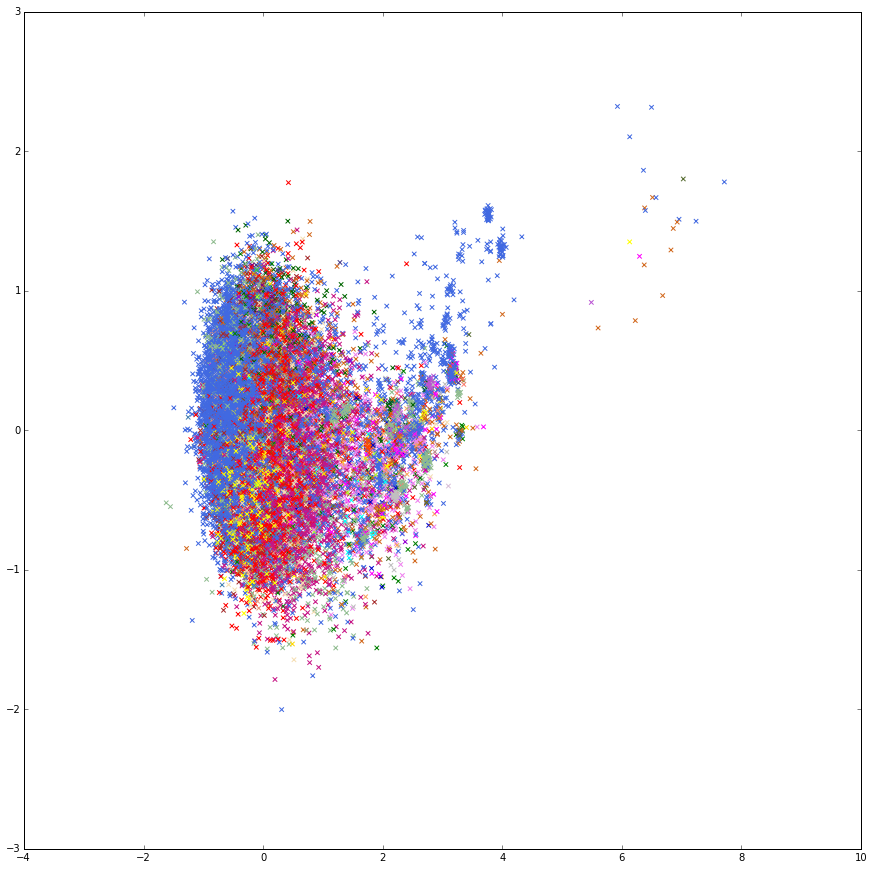

In [274]:
pl.scatter(x=Y[:,0],y=Y[:,4], c=colors, marker="x")

In [ ]:
import matplotlib
matplotlib.interactive(True)

from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(xs=Y[:,0],ys=Y[:,1],zs=Y[:,2], c=colors)


In [225]:
list(corpus.debate_type.value_counts().items())

[('BILLS', 27061),
 ('ADJOURNMENT', 6597),
 ('STATEMENTS BY MEMBERS', 3907),
 ('COMMITTEES', 3067),
 ("PRIVATE MEMBERS' BUSINESS", 2834),
 ('MATTERS OF PUBLIC IMPORTANCE', 2659),
 ('MISCELLANEOUS', 2251),
 ('CONSTITUENCY STATEMENTS', 1308),
 ('GRIEVANCE DEBATE', 1237),
 ('CONDOLENCES', 890),
 ('MINISTERIAL STATEMENTS', 887),
 ('MOTIONS', 490),
 ("GOVERNOR-GENERAL'S SPEECH", 406),
 ('PERSONAL EXPLANATIONS', 405),
 ('BUSINESS', 310),
 ('DELEGATION REPORTS', 240),
 ('PRIVATE MEMBERS’ BUSINESS', 220),
 ('DOCUMENTS', 201),
 ('CENSURE MOTION', 191),
 ("AUDITOR-GENERAL'S REPORTS", 129),
 ('DISSENT FROM RULING', 102),
 ('QUESTIONS WITHOUT NOTICE', 94),
 ('ADDRESS IN REPLY', 87),
 ('QUESTIONS TO THE SPEAKER', 80),
 ('PARLIAMENTARY ZONE', 79),
 ('PRIVILEGE', 75),
 ('DISTINGUISHED VISITORS', 46),
 ('MINISTERIAL ARRANGEMENTS', 45),
 ('QUESTIONS WITHOUT NOTICE: ADDITIONAL ANSWERS', 43),
 ('VALEDICTORY', 42),
 ('TARIFF PROPOSALS', 37),
 ('SPECIAL ADJOURNMENT', 36),
 ('LEAVE OF ABSENCE', 29),
 ('AUDI

In [215]:
def test_train_split(class_label, test_proportion=0.2, min_occurance=2):
    assert(min_occurance>=2)
    label_value_counts = corpus.loc[:,class_label].value_counts()
    subcorpus = corpus[:]
    for label in label_value_counts[label_value_counts<min_occurance].index:
        subcorpus = subcorpus[corpus.loc[:,class_label]!=label]
    assert(subcorpus.debate_type.value_counts().min()>1)

    while(True):
        train_index = np.random.rand(len(subcorpus))>test_proportion
        train_data = subcorpus[train_index]
        test_data = subcorpus[np.logical_not(train_index)]
        
        for label in set(subcorpus.loc[:,class_label]):
            if (not(label in train_data.loc[:,class_label].values) 
                or not(label in test_data.loc[:,class_label].values) ):
                    #One is missing it's chance, try again
                    break #Back to top of while loop, by exiting for loop
        else: #They all had it         
            return test_data,train_data

test_data,train_data = test_train_split("debate_type", 0.2, 100)

/usr/local/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [216]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_X = scaler.fit_transform(np.row_stack(train_data.embeddings))
test_data_X = scaler.transform(np.row_stack(test_data.embeddings))

In [217]:
from sklearn.svm import NuSVC, SVC, LinearSVC
#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}
svm = LinearSVC(class_weight="auto",  max_iter=200)
svm.fit(train_data_X, train_data.debate_type)

LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [218]:
from sklearn.metrics import confusion_matrix
labels = np.unique(train_data.debate_type)
train_pred  = svm.predict(train_data_X)
train_confuse_mat = confusion_matrix(train_data.debate_type, train_pred, labels)

In [219]:
from sklearn.metrics import confusion_matrix
test_pred  = svm.predict(test_data_X)
test_confuse_mat = confusion_matrix(test_data.debate_type, test_pred, labels)

In [223]:
labels

array(['ADJOURNMENT', 'BILLS', 'COMMITTEES', 'STATEMENTS BY MEMBERS'], dtype=object)

In [220]:
train_confuse_mat.diagonal()/train_confuse_mat.sum(axis=1)*100

array([ 61.66950596,  92.40541415,  77.45783628,  41.60513644])

In [221]:
test_confuse_mat.diagonal()/test_confuse_mat.sum(axis=1)*100

array([ 60.88280061,  91.61433321,  77.35849057,  37.24747475])

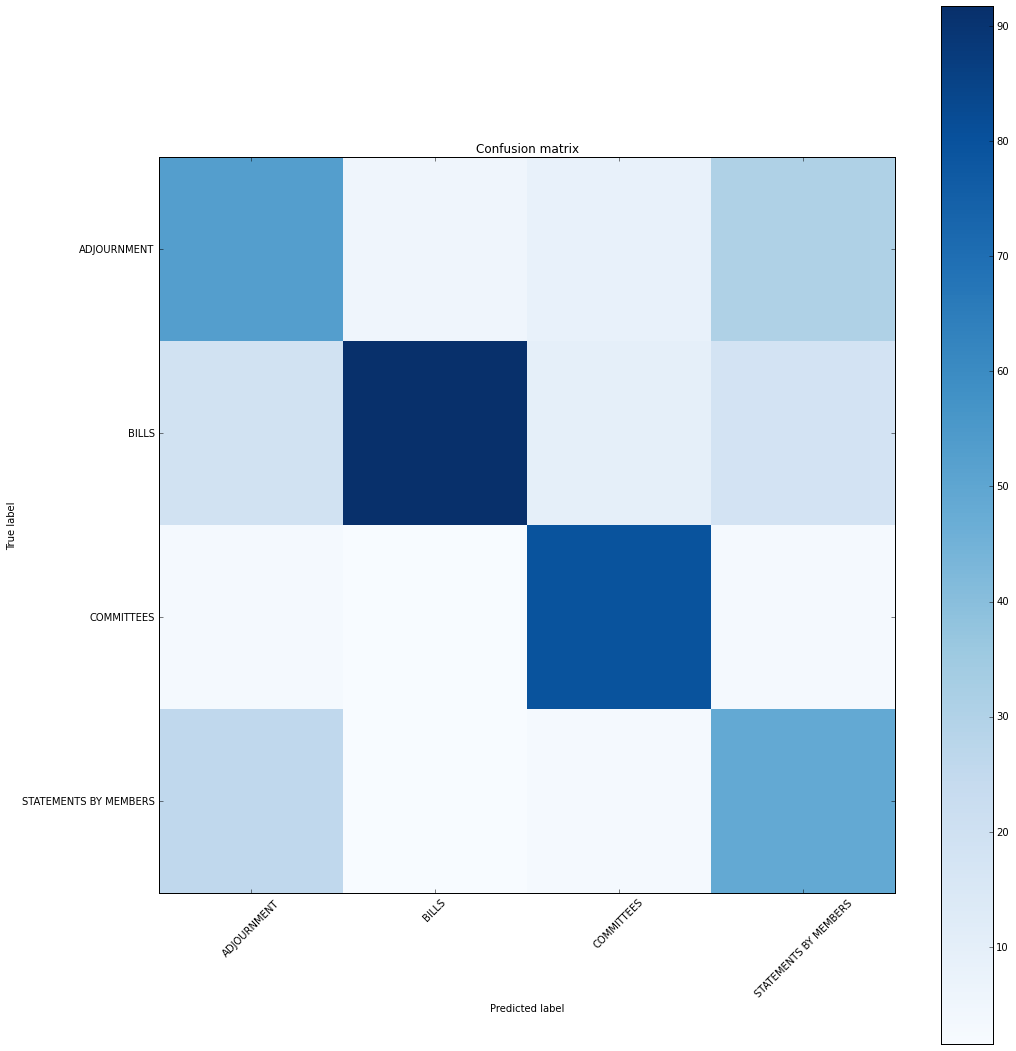

In [222]:
def plot_confusion_matrix(confuse_mat, labels, title='Confusion matrix', cmap=pl.cm.Blues):
    pl.imshow(confuse_mat, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=45)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')
    
def percent_confusion_matrix(confuse_mat):
    return confuse_mat/confuse_mat.sum(axis=0)*100.0

plot_confusion_matrix(percent_confusion_matrix(test_confuse_mat),labels)

In [297]:
xx

array([ 0.40947963,  0.04273642,  0.92550665,  0.79914532,  0.88773984,
        0.05787351,  0.91672018,  0.04055815,  0.59878072,  0.10481224,
        0.4448342 ,  0.97742869,  0.83963534,  0.30574915,  0.41775061,
        0.20536614,  0.9131017 ,  0.09184456,  0.05646392,  0.20926587,
        0.59939686,  0.51538178,  0.33079602,  0.14257698,  0.5800217 ,
        0.83268185,  0.95461271,  0.55143064,  0.00954003,  0.12140471])

array([[ 0.40947963,  0.04273642,  0.92550665,  0.79914532,  0.88773984,
         0.05787351,  0.91672018,  0.04055815,  0.59878072,  0.10481224,
         0.4448342 ,  0.97742869,  0.83963534,  0.30574915,  0.41775061,
         0.20536614,  0.9131017 ,  0.09184456,  0.05646392,  0.20926587,
         0.59939686,  0.51538178,  0.33079602,  0.14257698,  0.5800217 ,
         0.83268185,  0.95461271,  0.55143064,  0.00954003,  0.12140471],
       [ 0.40947963,  0.04273642,  0.92550665,  0.79914532,  0.88773984,
         0.05787351,  0.91672018,  0.04055815,  0.59878072,  0.10481224,
         0.4448342 ,  0.97742869,  0.83963534,  0.30574915,  0.41775061,
         0.20536614,  0.9131017 ,  0.09184456,  0.05646392,  0.20926587,
         0.59939686,  0.51538178,  0.33079602,  0.14257698,  0.5800217 ,
         0.83268185,  0.95461271,  0.55143064,  0.00954003,  0.12140471]])

In [318]:
count=500
xx = np.random.uniform(0,1,(count,))
yy=np.asarray([np.random.uniform(0,1,(count,)), np.zeros(count)]).T + np.asarray([xx,xx]).T